# **Using Vision Transformers in Medical Image Analysis**: *A SIIM Educational Notebook*

By: <i>Bardia Khosravi, MD MPH MHPE <sup>1,2</sup>, Pouria Rouzrokh, MD MPH MHPE <sup>1,2</sup>, Mana Moassefi, MD <sup>1</sup><i>

<b>1</b>. Mayo Clinic AI Lab, Department of Radiology, Mayo Clinic, Rochester, MN, USA

<b>2</b>. Orthopedic Surgery AI Lab (OSAIL), Department of Orthopedic Surgery, Mayo Clinic, Rochester, MN, USA

# 1. Introduction

Transformers were first introduced in the natural language processing (NLP) domain back in 2017, in the famous paper of ["Attention is All You Need"](https://arxiv.org/abs/1706.03762). For utilizing transformer models, the input is broken into parts, called *tokens*, and the model is trained to find how different tokens are correlated to each other. In the NLP domain, each word can be regarded as a token and the model will try to find how different words are conneted to each other. 

Attention, is the mechanism that powers transformers. Using attention, the model finds the pairwise similarity of tokens, enabling it to capture both spatial and content information. This capability to understand long-range similarities have helped transformers to outperform conventional LSTMs and RNNs.

In 2020, the paper titled ["An Image Is Worth 16x16 Words"](https://arxiv.org/abs/2010.11929) introduced Vision Transformers (ViT) to show the effectiveness of transformer-based architectures in computer vision tasks. Although ViTs are very powerful, but they need a lot of data to have their optimal performance. However After that, several architectural modifications have been proposed to make these models more robust and boost their performance. For example, [DeiT](https://arxiv.org/abs/2012.12877) is a training scheme that makes training the vision transformers more robust and less dependent on very large training pool; or [Swin Transformers](https://arxiv.org/abs/2103.14030) were introduced as an hierarchical transformer network, meaning that the image is seen in different resolutions just like what happens with Convolutional Neural Networks (CNN), which makes training the network easier and results in a higher performance, compared to both CNNs and its predecessor transformers. 

In this tutorial we will code the ViT architecture from scratch and train it on an example brain hemorrhage detection task. We will also see how we can leverage the [Pytorch image models (timm) package](https://github.com/rwightman/pytorch-image-models) to iterate with different architectures and how we can customize model specifications.

# 2. ViT Architecture

ViT architecture is very straightforward and implementing it can help understand the basics of other transformer-based models. ViT architecture is as follows:

<img src='https://i.ibb.co/WFsmbxs/Vi-TPicture1.png'>

As mentioned, attention is carried out by multiplication. However, when we are talking about images suppose 256px by 256px, multiplying each pixel by the others can easily fill up all the memory. To solve this, the authors propose to break the image into smaller pathches (like 16px by 16px) and only *attend* to pixels in each patch. You can see this makes computations much easier. But this arises another issue, how will the model know which patch belongs to where? For this, the authors add a new value to each patch called *positional embedding*, that goes from 1 to the number of patches, and demonstrate that after training the network will learn the spatial position of each patch <u><i>(Figure 7 of the paper)</u></i>:

<img src='https://i.ibb.co/yWb0YQN/Screenshot-4.png'>

So as the recepie, we break up each image is into several patches, and flatten it (to make multiplication easier) and concatenat it with a positional embedding. The resultant vector is passed through a Transformer encoder and the output vector of that is treated as the image features (like the output of the penultimate layer of CNNs). Finlly, a linear layer is used to serve as the classification *head*.

To break it down, the ViT architecture has three main parts:
1. Patch Embedding: This layer takes care of breaking up the image into smaller patches.
2. Transformer Encoder: This part is were the attention units are located.
3. Classifier Head: This layer decides which class an image belongs to based on the encoder features.

For the first part of this notebook, we assume the following initial hyper parameters:
- Input image size: 224px * 224px (grayscale, i.e., one channel)
- Number of classes: 10
- Patch size: 16px * 16px
- Embedding dimension: 768 *(will be explained more)*
- Number of attention heads: 12 *(will be explained more)*
- MLP dimention ration: 4 *(will be explained more)*
- Number of attention blocks: 10 *(will be explained more)*
- Batch size: 5

As we walk through this notebook, we will give the input and output shape of every operation so that you can have a better sense of what is happening in each line of the code.

Before we start, we need to import some modules from the pytorch library:

In [ ]:
import torch
import torch.nn as nn

Let's define the hyperparameters in code:

In [ ]:
input_size = 224
input_channels = 1
patch_size = 16
num_classes = 10
embed_dim = 768
attention_heads = 12
mlp_ratio = 4
num_attention_blocks = 10
batch_size = 5

## 2.1. Patch Embedding

This layer will convert the whole image into smaller patches. We can use convolutions with a kernel size and stride that equals our patch size (i.e., in this exmple 16). The `embed_dim` variable denotes the *hidden feature size* of the ViT.

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.n_patches, embed_dim)
        )

    def forward(self, x):
        x = self.proj(
                x
            )  # (batch, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (batch, embed_dim, n_patches)
        x = x.transpose(1, 2) # (batch, n_patches, embed_dim)

        batch_size = x.shape[0]

        cls_token = torch.repeat_interleave(self.cls_token, batch_size, dim=0) # (batch, 1, embed_dim)

        x = torch.cat((cls_token, x), dim=1) # (batch, n_tokens, embed_dim) n_tokens = n_patches + 1

        x = x + self.pos_embed 

        return x

<details>

<summary>
<font size="3" color="green">
<b>Optional: <font size="3" color="orange">Input & Output Dimensions</font></b>
</font>
</summary>

**Input:** (5, 1, 384, 384) *(batch size, channel, height, width)*

**Output:** (5, 577, 768) *(batch size, number of tokens, embedding dimension)* 

Note that number of tokens equals to number of patches+1 [to account for `cls token`].

</details>

Let's create an instance of this class and apply it on a randomly generated batch of images:

In [ ]:
patcher = PatchEmbed(img_size=input_size, patch_size=patch_size, in_chans=input_channels, embed_dim=embed_dim)
imgs = torch.rand(batch_size, input_channels, input_size, input_size)
patches = patcher(imgs)
print(patches.shape)

torch.Size([5, 197, 768])


So far, we have coded the first part of our ViT!

## 2.2. Transformer Encoder

The transformer encoder has several *blocks* (`L` in the below image), each composed of a series of *multi-headed attentions* (`h` in below image):


<img src='https://i.ibb.co/QPKyt3L/VITPicture2.png'>

Each block has two sub-parts, the QKV attention module and the multi-layer perceptron (MLP). Let's first start with these smaller sub-modules:

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        n_samples, n_tokens, dim = x.shape

        qkv = self.qkv(x) #(batch, n_tokens, embed_dim * 3)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        ) #(batch, n_tokens, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        ) # (3, batch, n_heads, n_tokens, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2] # 3 * (batch, n_heads, n_tokens, head_dim)
        k_t = k.transpose(-2, -1) # (batch, n_heads, head_dim, n_tokens)
        dp = (
           q @ k_t
        ) * self.scale # (batch, n_heads, n_tokens, n_tokens)
        attn = dp.softmax(dim=-1) # (batch, n_heads, n_tokens, n_tokens)

        
        weighted_avg = attn @ v # (batch, n_heads, n_tokens, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        ) # (batch, n_tokens, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (batch, n_tokens, embed_dim)

        x = self.proj(weighted_avg) # (batch, n_tokens, embed_dim)

        return x

Now that we have our `Attention` module, we need the `MLP` module:

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x) # (batch, n_tokens, hidden_features)
        x = self.act(x) 
        x = self.fc2(x) # (batch, n_tokens, out_features)

        return x

Putting it all together:

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

<details>

<summary>
<font size="3" color="green">
<b>Optional: <font size="3" color="orange">Input & Output Dimensions</font></b>
</font>
</summary>

**Input:** (5, 577, 768) *(batch size, number of tokens, embedding dimension)*

**Output:** (5, 577, 768) *(batch size, number of tokens, embedding dimension)*

Note that there is no size change before and after the attention blocks, which is one of useful charachteristics of this architectures.

</details>

We can test our `Block` in action:

In [ ]:
block = Block(dim=embed_dim, n_heads=attention_heads, mlp_ratio=mlp_ratio)
features = block(patches)
print(features.shape)

torch.Size([5, 197, 768])


That is all you need to code for a simple transformer encoder. Though it is a very simplified implementation and it can be improved, which has been done in newer transformer-based models.

## 2.3. Classifier Head

Now that we have our image features extracted by the transformer encoder, we need to have a classifier head that converts the feature dimension to the number of classes in our particular problem. It is noteworthy to mention that we only use the zero-th token information for classification purposes, and the rest is thrown out.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.norm = nn.LayerNorm(in_features, eps=1e-6)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.norm(x[:, 0]) # (batch, n_tokens, embed_dim)
        x = self.fc(x) # (batch, num_classes)

        return x

<details>

<summary>
<font size="3" color="green">
<b>Optional: <font size="3" color="orange">Input & Output Dimensions</font></b>
</font>
</summary>

**Input:** (5, 577, 768) *(batch size, number of tokens, embedding dimension)*

**Output:** (5, 10) *(batch size, number of classes)*

Note that there is no size change before and after the attention blocks, which is one of useful charachteristics of this architectures.

</details>

Let's create an instance of this class and see how it works:

In [ ]:
classifier = Classifier(in_features=embed_dim, num_classes=num_classes)
preds = classifier(features)
print(preds.shape)

torch.Size([5, 10])


Now we have a simple ViT that goes all the way from getting an input image, patch embedding it, passing it through the transformer block, and finally getting class probabilities.

# 3. Utilizing *timm*

Although it was fun to code the ViT architecture from scratch, it might not always be the best idea to do so. There are several actively maintained Python packages that have these models already implemented, and therefore can be used out of the box. One of the famous examples of these packages is [PyTorch image models (timm)](https://github.com/rwightman/pytorch-image-models). First we have to install this package:

In [ ]:
try:
    import timm
except ImportError:
    !pip install timm -q
    import timm

     |████████████████████████████████| 548 kB 9.1 MB/s 
     |████████████████████████████████| 163 kB 28.1 MB/s 


Timm provides a very flexible API that makes switching and experimenting with different models very easy. Additionally, it has pre-trained models (on ImageNet) that might be very helpful in transfer learning settings. We can essentially have the same model that we coded above in a single line of code:

In [ ]:
from timm.models.vision_transformer import VisionTransformer

model = VisionTransformer(
    img_size=input_size,
    patch_size=patch_size,
    in_chans=input_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=attention_heads,
    mlp_ratio=mlp_ratio,
    depth=num_attention_blocks,
)

Let's see the output of the model if we pass in our randomly generated images:

In [ ]:
output = model(imgs)
print(output.shape)

torch.Size([5, 10])


Correct! Now that we have this easy-to-use interface, we can leverage the pre-trained models by calling timm's `create_model` function:

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

Now that we have this model, we can proceed with training.

# 4. Model Training

In this section, we will train a sample ViT to detect brain hemorrhage on brain CT slices.

## 4.1. Requirements Setup

In [ ]:
#@markdown In this cell we install ITK (required for reading CT slices) and MONAI (for image transformation). You can double click this cell to show its content.
!pip install itk monai -q

     |████████████████████████████████| 1.1 MB 6.4 MB/s 
     |████████████████████████████████| 70.6 MB 8.9 kB/s 
     |████████████████████████████████| 95.3 MB 63.8 MB/s 
     |████████████████████████████████| 15.0 MB 22.3 MB/s 
     |████████████████████████████████| 20.3 MB 35.3 MB/s 
     |████████████████████████████████| 16.6 MB 32.1 MB/s 
     |████████████████████████████████| 54.5 MB 1.3 MB/s 


## 4.2. Downloading the Data

We will first download some toy data to train our ViT. This data comes from the publicly available [CQ500 dataset](http://headctstudy.qure.ai/dataset), which  consists of head CT scans of patients with brain hemorrhage. Each axial slice in this dataset has labels for one or more brain hemorrhage types. In the following cells, we will download all DICOM files from this dataset to our notebook.

In [ ]:
import shutil
import os

# Removing the "sample_data" folder that google colab creates by default
shutil.rmtree('sample_data', ignore_errors=True)

# Importing DICOM and label files to our working directory
if not os.path.exists('RSNA2021_YOLOv5_Workshop'):
  !git clone https://github.com/Mayo-Radiology-Informatics-Lab/RSNA2021_YOLOv5_Workshop.git
shutil.move('RSNA2021_YOLOv5_Workshop/DICOMs', 'DICOMs')
shutil.move('RSNA2021_YOLOv5_Workshop/labels.csv', 'labels.csv')
shutil.rmtree('RSNA2021_YOLOv5_Workshop')

Cloning into 'RSNA2021_YOLOv5_Workshop'...
remote: Enumerating objects: 3718, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 3718 (delta 36), reused 144 (delta 25), pack-reused 3563
Receiving objects: 100% (3718/3718), 571.90 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Checking out files: 100% (3562/3562), done.


## 4.3. Inspecting the Labels

The CQ500 dataset comes with a labels.csv file that contains one lesion per row. We need to change this to a dataframe that contains all labels for a single image per row. We will do that in the following cells. Please note that each image in our scenario has a unique SOPInstanceUID tag in the labels.csv file. We have already saved all of our images by their SOPInstanceUID tags, and this will help us to later identify the labels for each image in our dataset. 

In [ ]:
import pandas as pd

initial_df = pd.read_csv('labels.csv')
print('The following lesions exist in our dataset:')
print(initial_df['labelName'].value_counts())
initial_df.head()

The following lesions exist in our dataset:
Subdural            1849
Subarachnoid        1746
Intraparenchymal    1324
Chronic              740
Intraventricular     558
Epidural              66
Name: labelName, dtype: int64


,Unnamed: 0,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,data,labelName,labelType
0,95,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 236.16402999999997, 'y': 151.01577, 'wid...",Intraventricular,handDrawn
1,96,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 232.93374, 'y': 156.66877, 'width': 57.3...",Intraventricular,handDrawn
2,97,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 230.51106000000001, 'y': 147.78548999999...",Intraventricular,handDrawn
3,98,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 224.05046000000002, 'y': 151.82334, 'wid...",Intraventricular,handDrawn
4,99,1.2.276.0.7230010.3.1.4.296485376.1.1521713089...,1.2.276.0.7230010.3.1.3.296485376.1.1521713089...,1.2.276.0.7230010.3.1.2.296485376.1.1521713088...,"{'x': 287.04103, 'y': 297.99369, 'width': 52.4...",Intraventricular,handDrawn


We can have labels for each image as follows:

In [ ]:
lesion_dict = dict()

for i, row in initial_df.iterrows():
  img_name = row['SOPInstanceUID']
  lesions = lesion_dict.get( # getting default values as no hemorrhage is present
      img_name,
      {
        "subdural":0,
        "subarachnoid":0,
        "intraparenchymal":0,
        "chronic":0,
        "intraventricular":0,
        "epidural":0
      }
  )
  lesions[row['labelName'].lower()]=1
  lesion_dict[img_name] = lesions

# reorienting the dictionary as a list of dictionaries 
# (+ adding image path based on SOPInstanceUID)
final_data_list = []
for idx in lesion_dict:
    final_data_list.append({"img":f"./DICOMs/{idx}.dcm",**lesion_dict[idx]})

final_df = pd.DataFrame(final_data_list)
final_df.head()

,img,subdural,subarachnoid,intraparenchymal,chronic,intraventricular,epidural
0,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0
1,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0
2,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0
3,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,0,0,1,0
4,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0


## 4.4. Splitting the Data
We will now split our data to training and validation sets. To do this correctly, we must stratify our data according to their labels; that is, we must reserve portions of our data as training and validation sets so that those portions have nearly equal numbers of various lesions. We use the `sklearn` package to accomplish this.

In [ ]:
final_df['fold_data'] = \
  final_df['subdural'].astype(str)  + final_df['subarachnoid'].astype(str)  + \
  final_df['intraparenchymal'].astype(str)  + final_df['chronic'].astype(str) + \
  final_df['intraventricular'].astype(str)  + final_df['epidural'].astype(str)
final_df.head()

,img,subdural,subarachnoid,intraparenchymal,chronic,intraventricular,epidural,fold_data
0,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0,001010
1,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0,001010
2,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0,001010
3,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,0,0,1,0,000010
4,./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1...,0,0,1,0,1,0,001010


In [ ]:
from sklearn.model_selection import StratifiedKFold

X = final_df['img'].tolist()
Y = final_df['fold_data'].tolist()

cv = StratifiedKFold(n_splits=5)
train_idxs, valid_idxs = next(iter(cv.split(X, Y)))
train_df = final_df.loc[train_idxs]
valid_df = final_df.loc[valid_idxs]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Let's check our training and validation sample size:

In [ ]:
print(f'The train_df contains {len(train_df)} images.')
print(f'The valid_df contains {len(valid_df)} images.')

The train_df contains 2846 images.
The valid_df contains 712 images.


## 4.5. Data Pipeline
Here we will use MONAI and PyTorch to build our training and validation datasets and dataloaders. We will resize the images to 224 * 224 to accelerate our future training. To do so, we first need to convert our dataframes into a list dictionaries.

In [ ]:
train_data = train_df.to_dict(orient="records")
valid_data = valid_df.to_dict(orient="records")

We now have to setup our transformation pipelines and plug it into the MONAI's dataset inteface:

In [ ]:
import monai as mn
import torch

try: # to fix we rerun this cell, but please do not as it will remove the cache
    shutil.rmtree("./cache")
    print("Removed MONAI's Cache Directory.")
except:
    pass

WINDOW_WIDTH = 80
WINDOW_LEVEL = 40

train_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=['img'], reader="ITKReader"),
    mn.transforms.TransposeD(keys=['img'], indices=(2,1,0)), # W:H:C -> C:H:W
    mn.transforms.RepeatChannelD(keys=['img'], repeats=3),
    mn.transforms.ScaleIntensityRangeD(keys=['img'], a_min=WINDOW_LEVEL-(WINDOW_WIDTH/2), a_max=WINDOW_LEVEL+(WINDOW_WIDTH/2), b_min=0, b_max=1, clip=True),
    mn.transforms.ResizeD(keys=['img'], spatial_size=(224, 224)),
    mn.transforms.RandRotateD(keys=['img'], range_x=0.25, prob=0.8, padding_mode="zeros"),
    mn.transforms.RandFlipD(keys=['img'], prob=0.5, spatial_axis=1),
    mn.transforms.ToTensorD(keys=['img', 'subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural'], dtype=torch.float32),
    mn.transforms.AddChannelD(keys=['subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural']),
    mn.transforms.ConcatItemsD(keys=['subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural'], name='target'),
    mn.transforms.SelectItemsD(keys=["img","target"])
])

valid_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=['img'], reader="ITKReader"),
    mn.transforms.TransposeD(keys=['img'], indices=(2,1,0)),
    mn.transforms.RepeatChannelD(keys=['img'], repeats=3),
    mn.transforms.ScaleIntensityRangeD(keys=['img'], a_min=WINDOW_LEVEL-(WINDOW_WIDTH/2), a_max=WINDOW_LEVEL+(WINDOW_WIDTH/2), b_min=0, b_max=1, clip=True),
    mn.transforms.ResizeD(keys=['img'], spatial_size=(224, 224)),
    mn.transforms.ToTensorD(keys=['img', 'subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural'], dtype=torch.float32),
    mn.transforms.AddChannelD(keys=['subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural']),
    mn.transforms.ConcatItemsD(keys=['subdural', 'subarachnoid', 'intraparenchymal', 'chronic', 'intraventricular', 'epidural'], name='target'),
    mn.transforms.SelectItemsD(keys=["img","target"])
])

train_ds = mn.data.PersistentDataset(train_data, transform=train_transforms, cache_dir="./cache/train")
valid_ds = mn.data.PersistentDataset(valid_data, transform=valid_transforms, cache_dir="./cache/val")
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=8, shuffle=False, pin_memory=True, drop_last=False)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


Now we can visualize a sample of our training set:

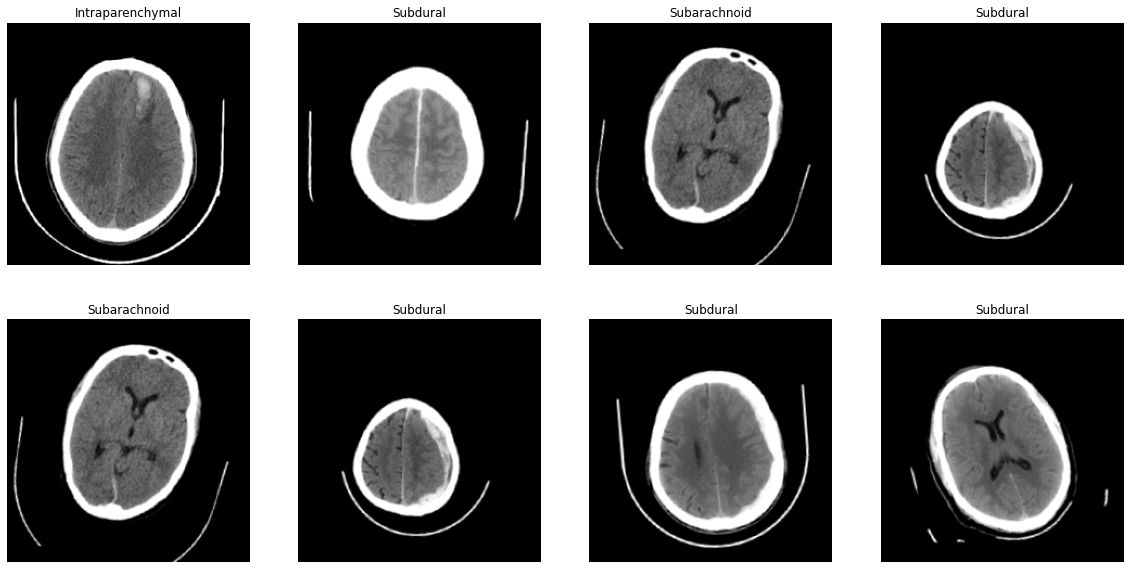

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_batch(batch, rows=2, cols=4):
    index_dict = {
        0: 'Subdural',
        1: 'Subarachnoid',
        2: 'Intraparenchymal',
        3: 'Chronic',
        4: 'Intraventricular',
        5: 'Epidural'
    }

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))                    

    if rows == 1 and cols == 1:
        axes.imshow(batch['img'][0,0], cmap='gray')
        labels = '-'.join([index_dict[k] for k in range(6) if int(batch['target'][0][k])==1])
        if len(labels) == 0:
            labels = 'None'
        axes.set_title(labels)
        axes.axis('off')
    else:
        for i in range(rows):
            for j in range(cols):
                index = i*2 + j
                axes[i, j].imshow(batch['img'][index][0], cmap='gray')
                labels = '-'.join([index_dict[k] for k in range(6) if int(batch['target'][index][k])==1])
                if len(labels) == 0:
                    labels = 'None'
                axes[i, j].set_title(labels)
                axes[i, j].axis('off')

    plt.show()

batch = next(iter(train_loader))
plot_batch(batch)

## 4.6. Training Loop
As discussed before, we will use the timm library to load a pre-trained small ViT model. We will then train this model for a few epochs to showcase how you can train your own models.

In [ ]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=6).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
loss_fn =  torch.nn.BCEWithLogitsLoss()

NUM_EPOCHS = 10

A very simple training loop is presented here:

In [ ]:
from tqdm.notebook import tqdm

train_epoch_loss_list = list()
valid_epoch_loss_list = list()

for epoch in range(NUM_EPOCHS):
  print(f'Starting epoch: {epoch+1}')
  
  # Training
  model.train()
  train_epoch_loss = 0
  pbar = tqdm(train_loader, desc='training')
  for batch in pbar:
    optimizer.zero_grad()
    imgs = batch['img'].cuda()
    targets = batch['target'].cuda()
    preds = model(imgs)
    loss = loss_fn(preds, targets)
    loss.backward()
    optimizer.step()
    pbar.set_postfix ({'loss': loss.item()})
    train_epoch_loss += loss.item()

  # Validation
  model.eval()
  valid_epoch_loss = 0
  pbar = tqdm(valid_loader, desc='validation')
  with torch.no_grad():
    for batch in pbar:
      imgs = batch['img'].cuda()
      targets = batch['target'].cuda()
      preds = model(imgs)
      loss = loss_fn(preds, targets)
      pbar.set_postfix ({'loss': loss.item()})
      valid_epoch_loss += loss.item()
  
  # Logging
  train_epoch_loss = train_epoch_loss/len(train_loader)
  valid_epoch_loss = valid_epoch_loss/len(valid_loader)
  
  train_epoch_loss_list.append(train_epoch_loss)
  valid_epoch_loss_list.append(valid_epoch_loss)
  print(f'Training loss at the end of epoch {epoch+1}: {train_epoch_loss}')
  print(f'Validation loss at the end of epoch {epoch+1}: {valid_epoch_loss}')
  print('*'*30)

Starting epoch: 1


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 1: 0.4282362309140219
Validation loss at the end of epoch 1: 0.4094691187813041
******************************
Starting epoch: 2


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 2: 0.33111612544932834
Validation loss at the end of epoch 2: 0.3833968753225348
******************************
Starting epoch: 3


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 3: 0.27468190071448473
Validation loss at the end of epoch 3: 0.3614670414938016
******************************
Starting epoch: 4


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 4: 0.23431752393363228
Validation loss at the end of epoch 4: 0.3414446601874373
******************************
Starting epoch: 5


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 5: 0.20194600715603628
Validation loss at the end of epoch 5: 0.38250903387585383
******************************
Starting epoch: 6


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 6: 0.1752890782666878
Validation loss at the end of epoch 6: 0.3750451619454314
******************************
Starting epoch: 7


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 7: 0.15004272828219642
Validation loss at the end of epoch 7: 0.3685849512812127
******************************
Starting epoch: 8


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 8: 0.13451684080588985
Validation loss at the end of epoch 8: 0.35648064666919493
******************************
Starting epoch: 9


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 9: 0.12205405141895925
Validation loss at the end of epoch 9: 0.33991415103834666
******************************
Starting epoch: 10


training:   0%|          | 0/355 [00:00<?, ?it/s]

validation:   0%|          | 0/89 [00:00<?, ?it/s]

Training loss at the end of epoch 10: 0.10267316462393378
Validation loss at the end of epoch 10: 0.3491675461945909
******************************


Next we will plot our loss curves:

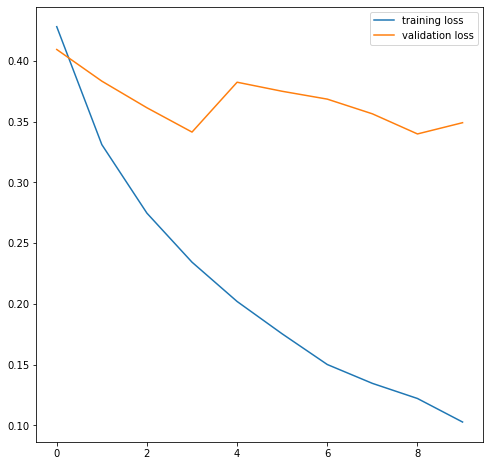

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(train_epoch_loss_list, label='training loss')
ax.plot(valid_epoch_loss_list, label='validation loss')
ax.legend()

As you can see above, our training has completed with a reasonable reduction in training loss values. However, our training process was far from ideal. Our validation loss started to increase, which implies a serious overfitting. While there are other things we can do to make our training more resistant to overfitting, discussing them is beyond the scope of the current notebook. More importantly, transformer models often need larger training datasets than what we had here to fit appropriately. Adding more training data and choosing better training strategies will likely improve our results. Feel free to play with the above code and try some of these strategies by yourself. As an example, you can try different variants of [timm](https://github.com/rwightman/pytorch-image-models#models).


> **Question**: What aspect of the data handling do you think needs to be improved? In other words if you could ask for one piece of information to complete your initial dataset what would that be?



Once you feel satisfied with your training results, you can save your model and use it for inference on your desired brain imaging data:

In [ ]:
weights_path = './weights.pth'
torch.save(model.state_dict(), weights_path)

# 5. Running Inference

Now that we have saved our checkpoint, we can run our model on a sample image. To do so, we first need to load our checkpoint weights:

In [ ]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=6, checkpoint_path='./weights.pth').to('cuda')

To prepare our data, we will create a transformation pipeline similar to our validation set and pass in an item, with only one difference, we will finally add a new dimension to simulate the batch dimension: 

In [ ]:
test_transforms = mn.transforms.Compose([
    mn.transforms.LoadImage(reader="ITKReader", image_only=True),
    mn.transforms.Transpose(indices=(2,1,0)),
    mn.transforms.RepeatChannel(repeats=3),
    mn.transforms.ScaleIntensityRange(a_min=WINDOW_LEVEL-(WINDOW_WIDTH/2), a_max=WINDOW_LEVEL+(WINDOW_WIDTH/2), b_min=0, b_max=1, clip=True),
    mn.transforms.Resize(spatial_size=(224, 224)),
    mn.transforms.ToTensor(dtype=torch.float32),
    mn.transforms.AddChannel() # simulating batch dimension
])

sample_image_path = "./DICOMs/1.2.276.0.7230010.3.1.4.296485376.1.1521714478.2064729.dcm"
sample_image = test_transforms(sample_image_path)

Note that in the above example, we used MONAI's vanilla transforms because we have only the image (no labels) as opposed to its dictionary based transforms.

Now we can run inference, do the post-processing by thresholding and create a "*fake*" batch to plot:

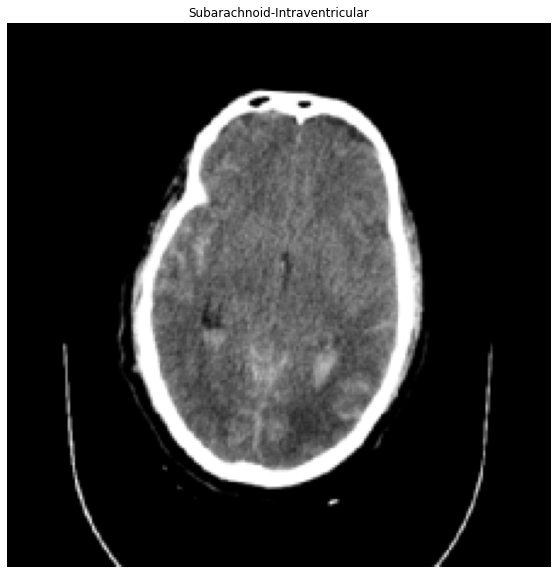

In [ ]:
sample_image = sample_image.cuda()
preds = model(sample_image)

post_trans = mn.transforms.AsDiscrete(threshold=0.5) # Thresholding the predictions
preds = post_trans(preds)

fake_batch = {"img":sample_image.cpu(), "target": preds.cpu()}

plot_batch(fake_batch, rows=1, cols=1)

You can change the `sample_image_path` variable pointing out to a different slice and see how your best model performs.

# 6. Final Remarks

In this tutorial, we went through the basic building blocks of modern transformer-based vision models. As mentioned previously, there are newer transformer models that improve upon the ViT and even outperform it. 

If you are interested to learn more about transformers, we suggest these additional resources:

- [An Image Is Worth 16x16 Words](https://arxiv.org/abs/2010.11929): This paper explains ViTs in more detail.
-  [Training data-efficient image transformers & distillation through attention](https://arxiv.org/abs/2012.12877): This paper proposes a training technique and a group of models called *DeiT*. This will enable training a ViT with limited number if data points.
- [Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030): This is the *Swin Transformer* paper, which change the architecture of ViT in a way that resembles some features of CNNs.